In [1]:
import csv
import pandas as pd
import numpy as np
from numpy.random import normal
from os import listdir
import os 

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.ticker as ticker
import seaborn as sns
from figure_dict import *
import statsmodels.api as sm
from lmfit import minimize, Minimizer, Parameters, report_fit
import re
from scipy import stats
from scipy.optimize import curve_fit
from collections import defaultdict
import numbers
from uncertainties import ufloat, umath, unumpy
from uncertainties.umath import *

import matplotlib as mpl
from matplotlib import cm
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, LogNorm

from decimal import Decimal
import itertools
from figure_dict import *
import math
%matplotlib inline 
plt.style.use('figures')


C:\ProgramData\Anaconda2\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
dirIn = "input/Function/"
dirOut = "input/Function/cleaned/"
dirOut2 = "output/Function/"
temp = 30
extracaption = "-"+str(temp)+"C"

dirIn = "input/Function/"
dirOut = "input/Function/cleaned/12mut-"
dirOut2 = "output/Function/12mut-"
temp = 30
extracaption = "-"+str(temp)+"C"

In [3]:
def trimDataset(df, startrow, endrow):
    numrow = endrow - startrow
    df = df.head(endrow) 
    df = df.tail(numrow) 
    df = df.reset_index(drop=True)
    return df

def get_sample_cond(protein, substrate):	
    samples = []
    for p, s in itertools.product(protein, substrate):
        cond = p+"-"+str(s)+"uMCdRP"
        samples.append(cond)
    return samples


def substrateBackground(df, protein, substrate):
    lst = list(df)
    substrateBackground = pd.DataFrame() 
    for p, s in itertools.product(protein, substrate):
        cond = p+"-"+str(s)+"uMCdRP"
        backSub = df["CdRP-"+str(s)+"uMCdRP"]
        substrateBackground[cond] = backSub
    return substrateBackground

def proteinBackground(df, protein, substrate):
    lst = list(df)
    proteinBackground = pd.DataFrame() 
    for p, s in itertools.product(protein, substrate):
        cond = p+"-"+str(s)+"uMCdRP"
        backProt = df[str(p+"-0uMCdRP")]
        proteinBackground[cond] = backProt
    return proteinBackground

def bufferBackground(df, protein, substrate):
    bufferBackground = pd.DataFrame() 
    for p, s in itertools.product(protein, substrate):
        cond = p+"-"+str(s)+"uMCdRP"
        backBuffer = df["CdRP-0uMCdRP"]
        bufferBackground[cond] = backBuffer
    return bufferBackground
def removeOutliersByConc(df, substrate, outliers):
    for o in outliers:
        curr_o = "-"+str(o)+"uM"
        df.drop([col for col in df.columns if curr_o in col],axis=1,inplace=True)
        substrate.remove(o)
    return (df, substrate)
def getVelocity(df, protlist, substrate):
    substrateOnly = "CdRP-"
    df = df.drop([col for col in df.columns if substrateOnly in col],axis=1)
    velocity = pd.DataFrame(columns = ["CdRP[uM]"] + protlist )
    deltaT = df.index.astype(float)
    for j in xrange(len(substrate)):
        vel = []
        vel.append(substrate[j])
        for i in xrange(len(protlist)):
            cond = protlist[i]+"-"+str(substrate[j])+"uMCdRP"
            deltaFl = df[cond]
            #ordinary least square, linear regression  
            slope = sm.OLS(deltaFl,deltaT).fit().params
            vel.append(slope[0])
        velocity.loc[len(velocity)]=vel
    return velocity
def concatDF (dfs):
    df = pd.concat(dfs, join = 'outer', axis =1)
    df.columns = df.columns.droplevel(0)
    df = df.groupby(by=df.columns, axis=1).apply(lambda g: g.mean(axis=1) if isinstance(g.iloc[0,0], numbers.Number) else g.iloc[:,0])  
    return df

def residual(params, x, y):
    V = params["V"].value
    K = params["K"].value
    r = params["r"].value
    model = ((V * x)/(K + x)) -r 
    #print model
    return model - y

def get_mm(x, V, K):
    Y = (V * x/(K + x))
    return Y

def getErrorFromSplit (uncertain_string):
    uncertain_string = '{:.6f}'.format(uncertain_string)
    value, err = uncertain_string.split("+/-")
    return ('%.6E' % Decimal(float(err)))

def getValueFromSplit (uncertain_string):
    uncertain_string = '{:.6f}'.format(uncertain_string)
    value, err = uncertain_string.split("+/-")
    #value = '{:.6ue}'.format(float(value))
    return ('%.6E' % Decimal(float(value)))

def propagateErrorDF(unumpyarray, df, colname):
    unumpyarray = ['{:.20f}'.format(i) for i in unumpyarray]
    tempSeries = pd.Series(unumpyarray, name = colname).apply(str)
    tempDF = pd.DataFrame([ x.split('+/-') for x in tempSeries.tolist() ], columns = [colname, colname + '_err'], index = df.index)
    df = df.join(tempDF)
    return (df)


def propagateErrorDFFormatted(unumpyarray, df, colname):
    #unumpyarray = ['{0:0.6f}'.format(i) for i in unumpyarray]
    tempSeries = pd.Series(unumpyarray, name = colname).apply(str)
    tempDF = pd.DataFrame([ x.split('+/-') for x in tempSeries.tolist() ], columns = [colname, colname + '_err'], index = df.index)
    tempDF[colname] = pd.to_numeric(tempDF[colname])
    tempDF[colname + '_err'] = pd.to_numeric(tempDF[colname + '_err'])
    df[colname] = tempDF[colname].round(6).map('{:0.2f}'.format) + u'\u00B1' +  tempDF[colname + '_err'].round(6).map('{:0.3f}'.format)
    return (df)

def autolabel(p, x, y, ax, err, intercept, slope):
    #get order of magnitude
    ordermag = pow(10, (math.ceil(math.log10((max(y))))))
    y_shift = ordermag/10 * 0.05
    for prot, x_val, y_val, e in zip(p, x, y, err):
        ypred = intercept+slope*x_val
        if (prot == "I45K\nI107A"):
            x_val = x_val+0.5
            y_shift = 0
            e = 0
        if (y_val > ypred):
            ax.text(x_val, y_val+y_shift+e, prot, ha='center', va='bottom', size=14)
        else:
            ax.text(x_val, y_val-y_shift-e, prot, ha='center', va='top', size=14)    
            
    return


In [4]:
#save df to list 
velmeanexpt = []
velstdexpt = []

for pl in range(1, 3):
    velmean = {}
    velstd = {}
    for s in range(1, 3):
        dfs = {}
        vels = {}
        for r in range(1,4):
            if (pl == 1): 
                substrate = [0, 100, 200, 300, 400, 500, 600, 725, 850, 975, 1100, 1250]
                protein =   ["SsWT", "I45A", "I45K", "S70A", "M73A", "I107A", "I107K","CdRP"]
                numReps = 3
                outliers = [1100, 1250]
            elif (pl == 2):
                substrate = [0, 100, 200, 300, 400, 500, 600, 725, 850, 975, 1100, 1250]
                protein =   ["I45A_S70A", "I45A_M73A", "I45K_S70A", "I45K_I107A", "M73A_I107K", "I45K_I107K", "S70A_I107K", "CdRP"]
                numReps = 3
                outliers = [1100, 1250]
            else:
                pass

            expt = "20180527-SsMutants"
            fname = expt+"-Set"+str(s)+"-P"+str(pl)+"-Rep"+str(r)
            fin = dirIn+fname+".xlsx"
            #print (fin)
            protlist =  [ p for p in protein if p != "CdRP" ]
            proteinconc = 1 #in units of [uM]
            df = pd.read_excel(fin)   
            df = trimDataset(df, 45, 143).T.set_index(0).drop([1], axis=1).iloc[1:]
            sample_cond = get_sample_cond(protein, substrate)
            df.columns = sample_cond 
            df.index.names = ['Time(s)']
            df = df.astype(float)

            #returns dataframes with approprate backgrounds for subtraction 
            subBackground  = substrateBackground(df, protein, substrate)
            protBackground = proteinBackground(df, protein, substrate)
            buffBackground = bufferBackground(df, protein, substrate)

            #subtract background from sample reads 
            df = df.sub(subBackground, axis=0).sub(protBackground, axis=0).add(buffBackground, axis=0)
            df, substrate = removeOutliersByConc(df, substrate, outliers)
            df.head()
            foutrep  = dirOut+fname+'-bkgSubtracted.csv'
            foutrep2  = dirOut+fname+'-vi-bkgSubtracted.csv'
            dfs[r] = df #save each rep into array for panel 
            dfs[r].to_csv(foutrep, sep=',' , index=False)
            cur_vel = getVelocity(df, protlist, substrate)
            for column in cur_vel:
                outlier = cur_vel[column] +0.5 < cur_vel[column].shift()
                idx = cur_vel.index[outlier] 
                for i in idx:
                    cur_vel.at[i, column] = np.NaN
            vels[r] = cur_vel
            vels[r].to_csv(foutrep2, sep=',' , index=False)
            
        #get mean and std of velocities between reps
        foutset = dirOut+expt+"-Plate"+str(pl)+'set'+str(s)+'-meanReps-vi-mean.csv'   
        foutset2 = dirOut+expt+"-Plate"+str(pl)+'set'+str(s)+'-meanReps-vi-std.csv' 
        dfpanel = pd.Panel(dfs)
        dfmean = dfpanel.mean(axis=0); 
        dfstd = dfpanel.std(axis=0); 
        
        velpanel = pd.Panel(vels)
        velmean[s] = velpanel.mean(axis=0)
        velmean[s].to_csv(foutset, sep=',' , index=False)
        
        velstd[s] = velpanel.std(axis=0)
        velstd[s].to_csv(foutset2, sep=',' , index=False)
    #get mean and std of velocities between experiments  
    velmeanpanel = pd.Panel(velmean)
    curr_velmean = velmeanpanel.mean(axis=0)
    curr_velmean.set_index(curr_velmean["CdRP[uM]"], inplace=True)
    curr_velmean = curr_velmean.drop("CdRP[uM]", 1)
    velmeanexpt.append(curr_velmean)
    
    velstdpanel = pd.Panel(velstd)
    curr_velstd = velstdpanel.mean(axis=0)
    curr_velstd = curr_velstd.drop("CdRP[uM]", 1)
    curr_velstd.set_index(curr_velmean.index, inplace=True)
    velstdexpt.append(curr_velstd)

foutexpt = dirOut+expt+"-meanSets-vi-mean.csv"
foutexpt2 = dirOut+expt+"-meanSets-vi-std.csv"
velocity = pd.concat(velmeanexpt, axis=1)
velstd = pd.concat(velstdexpt, axis=1)
velocity.to_csv(foutexpt, sep=',' , index=True)
velstd.to_csv(foutexpt2, sep=',' , index=True)

In [5]:
velocity = velocity.drop(['M73A_I107K'], axis = 1)
velocity

,SsWT,I45A,I45K,S70A,M73A,I107A,I107K,I45A_S70A,I45A_M73A,I45K_S70A,I45K_I107A,I45K_I107K,S70A_I107K
CdRP[uM],,,,,,,,,,,,,
0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
100.0,2.130410,1.740998,2.194936,2.352576,0.945264,2.821944,2.745438,1.893859,1.173783,1.973405,2.284162,2.884205,2.661149
200.0,3.278744,2.789897,3.756346,3.508154,1.331389,4.376078,4.506686,2.906998,2.076109,3.383354,3.618347,4.661754,4.545046
300.0,4.337698,3.612408,4.796897,4.709087,1.609792,5.644546,6.135064,4.151294,2.809265,4.497271,4.950010,6.111205,6.290129
400.0,5.158625,4.030747,5.724776,5.275155,1.809696,6.428100,6.871707,4.822428,3.191866,5.357179,5.529146,7.047350,7.083325
500.0,5.277153,4.095825,5.861417,5.674206,1.866296,6.665527,7.722331,5.167936,3.200527,5.568134,6.102806,7.510669,7.574163
600.0,5.979478,4.499587,6.641268,6.098560,2.196297,7.681928,8.417837,5.736923,3.677103,6.326664,6.605403,8.311084,8.713192
725.0,6.546393,5.021838,7.126284,6.860926,2.328816,8.091408,9.053509,6.453893,4.249317,7.017354,7.490285,8.762435,9.221516
850.0,6.714591,5.031129,7.448851,6.989100,2.622928,8.567455,9.420026,6.690058,4.331323,7.612424,7.784102,9.318161,9.704359


In [6]:
protlist = list(velocity)
print protlist
velocity["CdRP[uM]"] = velocity.index
velocity.reset_index(inplace=True, drop=True)
velocity

['SsWT', 'I45A', 'I45K', 'S70A', 'M73A', 'I107A', 'I107K', 'I45A_S70A', 'I45A_M73A', 'I45K_S70A', 'I45K_I107A', 'I45K_I107K', 'S70A_I107K']


,SsWT,I45A,I45K,S70A,M73A,I107A,I107K,I45A_S70A,I45A_M73A,I45K_S70A,I45K_I107A,I45K_I107K,S70A_I107K,CdRP[uM]
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,2.130410,1.740998,2.194936,2.352576,0.945264,2.821944,2.745438,1.893859,1.173783,1.973405,2.284162,2.884205,2.661149,100.0
2,3.278744,2.789897,3.756346,3.508154,1.331389,4.376078,4.506686,2.906998,2.076109,3.383354,3.618347,4.661754,4.545046,200.0
3,4.337698,3.612408,4.796897,4.709087,1.609792,5.644546,6.135064,4.151294,2.809265,4.497271,4.950010,6.111205,6.290129,300.0
4,5.158625,4.030747,5.724776,5.275155,1.809696,6.428100,6.871707,4.822428,3.191866,5.357179,5.529146,7.047350,7.083325,400.0
5,5.277153,4.095825,5.861417,5.674206,1.866296,6.665527,7.722331,5.167936,3.200527,5.568134,6.102806,7.510669,7.574163,500.0
6,5.979478,4.499587,6.641268,6.098560,2.196297,7.681928,8.417837,5.736923,3.677103,6.326664,6.605403,8.311084,8.713192,600.0
7,6.546393,5.021838,7.126284,6.860926,2.328816,8.091408,9.053509,6.453893,4.249317,7.017354,7.490285,8.762435,9.221516,725.0
8,6.714591,5.031129,7.448851,6.989100,2.622928,8.567455,9.420026,6.690058,4.331323,7.612424,7.784102,9.318161,9.704359,850.0
9,6.799582,5.154823,7.657030,7.285469,2.621750,8.789659,9.822152,6.806083,4.530583,7.715639,8.094500,9.624633,10.094122,975.0


## Figure 5 - a - initial velocity ##

C:\ProgramData\Anaconda2\lib\site-packages\matplotlib\figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


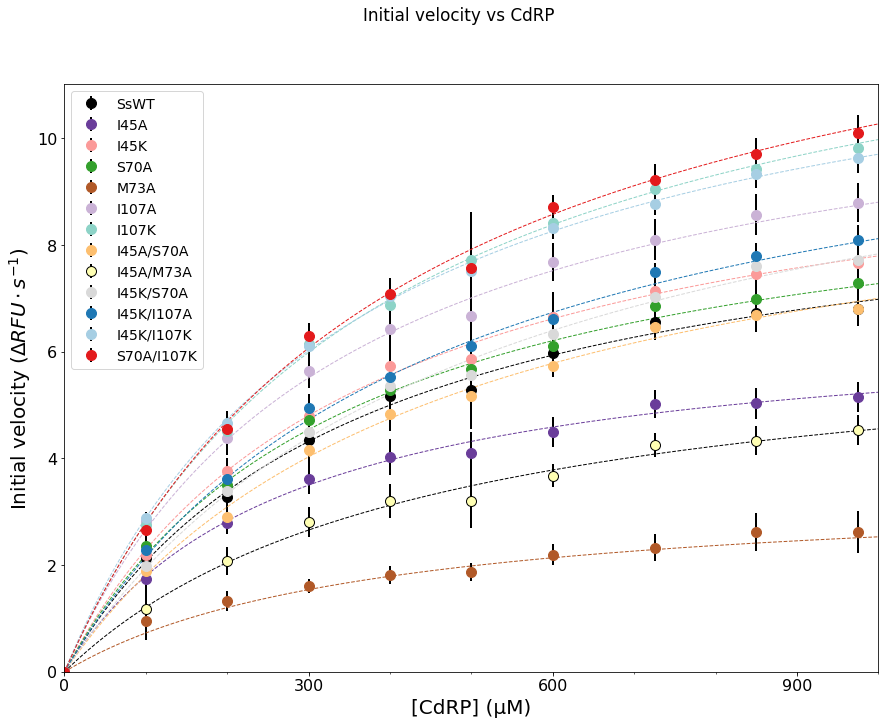

In [7]:
## no residuals
fig = plt.figure(figsize=(figsize["Height"],figsize["Double"])) 
gs = gridspec.GridSpec(nrows=1, ncols=1)
ax1 = plt.subplot(gs[0])

fig_title =  "Initial velocity vs CdRP"
my_suptitle = plt.suptitle(fig_title)

ax1.set_xlabel(labeldict["CdRP"])
ax1.set_ylabel(labeldict["initialvel"])



x_conc = pd.Series(velocity["CdRP[uM]"])
ymax = -1

#get fit of proteins
resid = dict()
resid = {"CdRP[uM]": x_conc.tolist()}
fit = pd.DataFrame(columns = ("Protein", "[Protein] (uM)", "Vmax (uM/s)", "Vmax_err","kcat (1/s)", "kcat_err",
                              "Km (uM)", "Km_err","kcat/km (uM-1*s-1)", "kcat/km (uM-1*s-1)_err"))
for i, p in enumerate(protlist):
    y = pd.to_numeric(velocity[p]).astype('float')
    #jitter for x to see scatterpoints 
    x = pd.to_numeric(x_conc).astype('float')
    e = pd.to_numeric(velstd[p]).astype('float')

    xmin = int(x_conc.min())
    xmax = int(x.max()) 
    #concentration to add for extrapolation 
    extendx = 100
    extended_xmax = xmax + extendx
    
    vmax = float(y.max())
    vmin = float(y.min())
    if (vmax > ymax):
        ymax = vmax
    vmaxhalf = (vmax+vmin)/2
    #list of y values close to cmaxhalf
    v_halfmax = y <= vmaxhalf
    #get index of y at half max
    conc_halfmax = y.loc[v_halfmax].idxmax()
    #print conc_halfmax, vmax, vmin
    params = Parameters()
    params.add("V", value = vmax+0.1, max = vmax+1000.0) # vmax estimate
    params.add("K", value = conc_halfmax, max = conc_halfmax+1000.0)# # km estimate
    params.add("r", value = vmin+0.01)
    
    # do fit, here with leastsq model
    result = minimize(residual, params, args=(x, y))
    new_vmax = result.params["V"].value
    new_km = result.params["K"].value
    #standard error = 1 sigma 
    new_vmax_err = result.params["V"].stderr
    new_km_err = result.params["K"].stderr
    #print new_vmax, new_km
    
    new_vmax_u = ufloat(new_vmax, new_vmax_err)
    new_km_u = ufloat(new_km, new_km_err)
    kcat_u = new_vmax_u/proteinconc
    keff_u = (new_vmax_u/proteinconc)/new_km_u
    kcat = getValueFromSplit(kcat_u)
    keff = getValueFromSplit(keff_u)
    fit.loc[len(fit)]=(p, proteinconc, round(new_vmax,3), getErrorFromSplit(new_vmax_u), 
                       kcat, getErrorFromSplit(kcat_u), round(new_km, 3), getErrorFromSplit(new_km_u),
                       keff, getErrorFromSplit(keff_u))
    resid.update({p: result.residual})
    #extrapolated_x = x.append( pd.Series([extended_xmax]), ignore_index=True)
    extrapolated_x = np.linspace(0, extended_xmax, num=2000)
    extrapolated_y = get_mm(extrapolated_x, new_vmax, new_km)
    #extrapolated_y = y.append( pd.Series([(new_vmax * extrapolated_x/(new_km + extrapolated_x))]), ignore_index=True)
    marker_p =   ["o"] * len(protlist)
    markersize_p =  [100] * len(protlist) 
    markersize_err_p =  [10] * len(protlist) 
    markerdict = dict(zip(protlist, marker_p))
    sizedict = dict(zip(protlist, markersize_p))
    size_err_dict = dict(zip(protlist, markersize_err_p))
    if "_r" in p:
        prot = p.split("_r")[0]
    else: 
        prot = p
    
    if prot == 'I45A_M73A':
        ax1.errorbar(x, y, yerr = e, fmt='o', markersize=size_err_dict[prot],  linewidth='0.8',markeredgecolor='black',
                 capsize=0, c= colordictCat[prot], label=p, elinewidth = '2',ecolor='black') #markeredgecolor='black',
        ax1.plot(extrapolated_x, extrapolated_y, ls = "--", lw = 1,  c= 'black', label='_nolegend_')
    else:
        ax1.errorbar(x, y, yerr = e, fmt='o', markersize=size_err_dict[prot],  linewidth='0.8',
                 capsize=0, c= colordictCat[prot], label=p, elinewidth = '2',ecolor='black') #markeredgecolor='black',
        ax1.plot(extrapolated_x, extrapolated_y, ls = "--", lw = 1,  c= colordictCat[prot], label='_nolegend_')
    #ax2.scatter(x, result.residual, c= colordictCat[prot], s=sizedict[prot], marker=markerdict[prot], linewidth='0.5', edgecolor='black')

ax1.set_xlim([0,1000]) #to see last point
ax1.set_ylim(bottom=0)
#add minor ticks at every 100 interval 
ax1.xaxis.set_major_locator(ticker.MultipleLocator(300))
ax1.xaxis.set_minor_locator(ticker.MultipleLocator(100))
ax1.tick_params(axis='both') 


fitMatrix = fit.as_matrix()
handles, labels = ax1.get_legend_handles_labels()
labels = [w.replace('_', '/') for w in labels]

ax1.xaxis.labelpad = 5
lgd = ax1.legend(handles, labels, loc='upper left', bbox_to_anchor=(1, 1), numpoints = 1 )

lgd.get_frame().set_linewidth(0.0)
lgd = ax1.legend(handles, labels, loc='upper left', bbox_to_anchor=(0, 1), numpoints = 1 )

fig.show()
fout = dirOut2 + 'Function-initialvelocity-noresiduals.pdf'
#
fig.savefig(fout, bbox_extra_artists=(lgd,my_suptitle), bbox_inches='tight')



In [8]:
fit = fit.set_index("Protein")
fit = fit.astype('float')

#temp in kelvin
T = temp + 273.15 
#gas constant in kcal/K*mol
R = 1.985*10**-3
fit["kcat/km (M-1*s-1)"] = fit["kcat/km (uM-1*s-1)"]*10**-6
fit["kcat/km (nM-1*s-1)"] = fit["kcat/km (uM-1*s-1)"]*1000
fit["kcat/km_err"] = fit["kcat/km (uM-1*s-1)_err"]*1000
ddG = fit.filter(["Km (uM)","Km_err", "kcat (1/s)","kcat_err","kcat/km (nM-1*s-1)","kcat/km_err"], axis=1)
ddG = ddG.drop('SsWT', axis=0)
ddG_u = pd.DataFrame(index=ddG.index)

km_wt = fit["Km (uM)"]["SsWT"] #values 
km_wt_err = fit["Km_err"]["SsWT"]
ddG["ddG_km (kcal/mol)"] = (-R*T*np.log(ddG["Km (uM)"]/km_wt))


kcat_wt = fit["kcat (1/s)"]["SsWT"] #values 
kcat_wt_err = fit["kcat_err"]["SsWT"]
ddG["ddG_kcat (kcal/mol)"] = (-R*T*np.log(ddG["kcat (1/s)"]/kcat_wt))

keff_wt = fit["kcat/km (nM-1*s-1)"]["SsWT"] #values 
keff_wt_err = fit["kcat/km_err"]["SsWT"] #values 
ddG["ddG_keff (kcal/mol)"] = (-R*T*np.log(ddG["kcat/km (nM-1*s-1)"]/keff_wt))


In [9]:
def splitErrArray(unumpyarray, colname):
    #unumpyarray = ['{0:0.6f}'.format(i) for i in unumpyarray]
    tempSeries = pd.Series(unumpyarray, name = colname).apply(str)
    tempDF = pd.DataFrame([ x.split('+/-') for x in tempSeries.tolist() ], columns = [colname, colname + '_err'], index = unumpyarray.index)
    tempDF[colname] = pd.to_numeric(tempDF[colname])
    tempDF[colname + '_err'] = pd.to_numeric(tempDF[colname + '_err'])
    return tempDF

In [10]:
km_wt_u = ufloat(km_wt, km_wt_err)
kcat_wt_u = ufloat(kcat_wt, kcat_wt_err)
keff_wt_u = ufloat(keff_wt, keff_wt_err)

ddG_u["Km (uM)"] = unumpy.uarray(ddG["Km (uM)"], ddG["Km_err"])
ddG_u["kcat (1/s)"] = unumpy.uarray(ddG["kcat (1/s)"], ddG["kcat_err"])
ddG_u["kcat/km (nM-1*s-1)"]  = unumpy.uarray(ddG["kcat/km (nM-1*s-1)"], ddG["kcat/km_err"])

ddG_u["Km/wt"] = ddG_u["Km (uM)"]/km_wt_u
ddG_u["kcat/wt"] = ddG_u["kcat (1/s)"]/kcat_wt_u
ddG_u["keff/wt"] = ddG_u["kcat/km (nM-1*s-1)"]/keff_wt_u


In [11]:
def propageErrLog (df): 
    x = np.log(df.iloc[:,0]) 
    err = 0.434*df.iloc[:,1]/df.iloc[:,0]
    return unumpy.uarray(x, err)

In [12]:
ddG_u["log_Km/wt"] = propageErrLog (splitErrArray(ddG_u["Km/wt"], "Km/wt"))
ddG_u["log_kcat/wt"] = propageErrLog (splitErrArray(ddG_u["kcat/wt"], "kcat/wt"))
ddG_u["log_keff/wt"] = propageErrLog (splitErrArray(ddG_u["keff/wt"], "keff/wt"))

ddG_u["ddG_Km (kcal/mol)"] = (-R*T*ddG_u["log_Km/wt"])
ddG_u["ddG_kcat (kcal/mol)"] = (-R*T*ddG_u["log_kcat/wt"])
ddG_u["ddG_keff (kcal/mol)"] = (-R*T*ddG_u["log_keff/wt"])


In [13]:
ddG5 = splitErrArray(ddG_u["ddG_Km (kcal/mol)"], "ddG_Km (kcal/mol)")
fit = fit.join(ddG5)
ddG3 = splitErrArray(ddG_u["ddG_kcat (kcal/mol)"], "ddG_kcat (kcal/mol)")
fit = fit.join(ddG3)
ddG4 = splitErrArray(ddG_u["ddG_keff (kcal/mol)"], "ddG_keff (kcal/mol)")
fit = fit.join(ddG4)

In [14]:
fit

,[Protein] (uM),Vmax (uM/s),Vmax_err,kcat (1/s),kcat_err,Km (uM),Km_err,kcat/km (uM-1*s-1),kcat/km (uM-1*s-1)_err,kcat/km (M-1*s-1),kcat/km (nM-1*s-1),kcat/km_err,ddG_Km (kcal/mol),ddG_Km (kcal/mol)_err,ddG_kcat (kcal/mol),ddG_kcat (kcal/mol)_err,ddG_keff (kcal/mol),ddG_keff (kcal/mol)_err
Protein,,,,,,,,,,,,,,,,,,
SsWT,1.0,9.492,0.322110,9.491778,0.322110,359.812,38.40956,0.026380,0.002955,2.638000e-08,26.380,2.955,NaN,NaN,NaN,NaN,NaN,NaN
I45A,1.0,6.658,0.212532,6.657556,0.212532,271.035,29.57755,0.024563,0.002793,2.456300e-08,24.563,2.793,0.170,0.040,0.214,0.012,0.040,0.040
I45K,1.0,10.632,0.280754,10.631710,0.280754,364.266,30.12436,0.029187,0.002534,2.918700e-08,29.187,2.534,-0.010,0.040,-0.068,0.012,-0.060,0.040
S70A,1.0,9.808,0.275739,9.808426,0.275739,348.454,31.16387,0.028148,0.002639,2.814800e-08,28.148,2.639,0.018,0.035,-0.018,0.013,-0.040,0.040
M73A,1.0,3.490,0.249587,3.489917,0.249587,379.746,83.73555,0.009190,0.002130,9.190000e-09,9.190,2.130,-0.040,0.060,0.602,0.021,0.630,0.070
I107A,1.0,11.824,0.339187,11.823790,0.339187,343.830,31.52225,0.034388,0.003303,3.438800e-08,34.388,3.303,0.025,0.035,-0.134,0.013,-0.160,0.040
I107K,1.0,13.959,0.231776,13.959050,0.231776,399.697,20.05579,0.034924,0.001846,3.492400e-08,34.924,1.846,-0.063,0.031,-0.232,0.011,-0.167,0.032
I45A_S70A,1.0,10.234,0.390907,10.233940,0.390907,462.290,50.14680,0.022138,0.002546,2.213800e-08,22.138,2.546,-0.150,0.040,-0.046,0.015,0.100,0.040
I45A_M73A,1.0,6.559,0.376537,6.559321,0.376537,440.833,73.39477,0.014879,0.002620,1.487900e-08,14.879,2.620,-0.120,0.050,0.223,0.019,0.350,0.060


In [15]:
def createScatterWithLinearRegression(df, fout,  x_col, y_col, x_err_col, y_err_col):
    x = df[x_col].astype('float')
    y = df[y_col].astype('float')
    x_err = df[x_err_col].astype('float')
    y_err = df[y_err_col].astype('float')
    col_p = df["color_p"]
    lab = df["label_p"]
    prot = df.index

    fig = plt.figure(figsize=(figsize["Height"],figsize["Double"])) 
    gs = gridspec.GridSpec(nrows=1, ncols=1)
    ax1 = plt.subplot(gs[0])
    fig_title = labeldict[y_col]+ " vs " + labeldict[x_col]
    #fig.suptitle(fig_title, fontsize=20)
    plt.subplots_adjust(hspace=0.1)
    ax1.set_xlabel(labeldict[x_col])
    ax1.set_ylabel(labeldict[y_col])
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

    for x_val, y_val, x_e, y_e, c, l, p in zip(x, y, x_err, y_err, col_p, lab, prot):
        if "I45A_M73" in p:
            c = "black" 
        ax1.errorbar(x_val, y_val, xerr = x_e, yerr = y_e, markersize = 0, 
                     markeredgecolor='black', linewidth='0.8', c= c, label=l,
                     elinewidth = '1', capsize=0, fmt='o', zorder=2,ecolor='black')
    ax1.scatter(x, y, c= col_p, marker='o', s=120, zorder=3)
    #ax1.set_xlim(axesdict2D[x_col][0],axesdict2D[x_col][1])
    #ax1.set_ylim(axesdict2D[y_col][0],axesdict2D[y_col][1])

    xx = np.linspace(0,max(x)+2,axesdict2D[x_col][1], 100)
    #print xx
    ax1.plot(xx, intercept+slope*xx, '--k', zorder=1)
    #plt.xlim(2, 16)
    autolabel(lab, x, y, ax1, y_err, intercept, slope)
    ax1.text(min(x), max(y), u'$R= %.2f$' % r_value,size=25,  ha='left', va='center', color= 'r')

    wtx = x[0]
    wty = y[0]
    ax1.axvline(x=wtx, color = "grey", linestyle = ":", zorder=0)
    ax1.axhline(y=wty, color = "grey", linestyle = ":", zorder=0)
    plt.xlim(min(x)-2,max(x)+2)

    ## red to blue colorbar
    cmap = mpl.cm.get_cmap("coolwarm")
    norm = mpl.colors.Normalize(vmin= -0.2, vmax=0.2)
    m = cm.ScalarMappable(norm=norm, cmap=cmap)
    m.set_array([])
    cbar = plt.colorbar(m)
    cbar.set_label('s', rotation=90,labelpad=10)
    
    fig.subplots_adjust(top = 0.88)
    ax1.tick_params(axis='both') 
    fig.tight_layout()
    fig.show()
    fig.savefig(fout)
    return

## Figure 5 - b ##

output/Function/12mut-Function-Keff_vs_Kcat.pdf


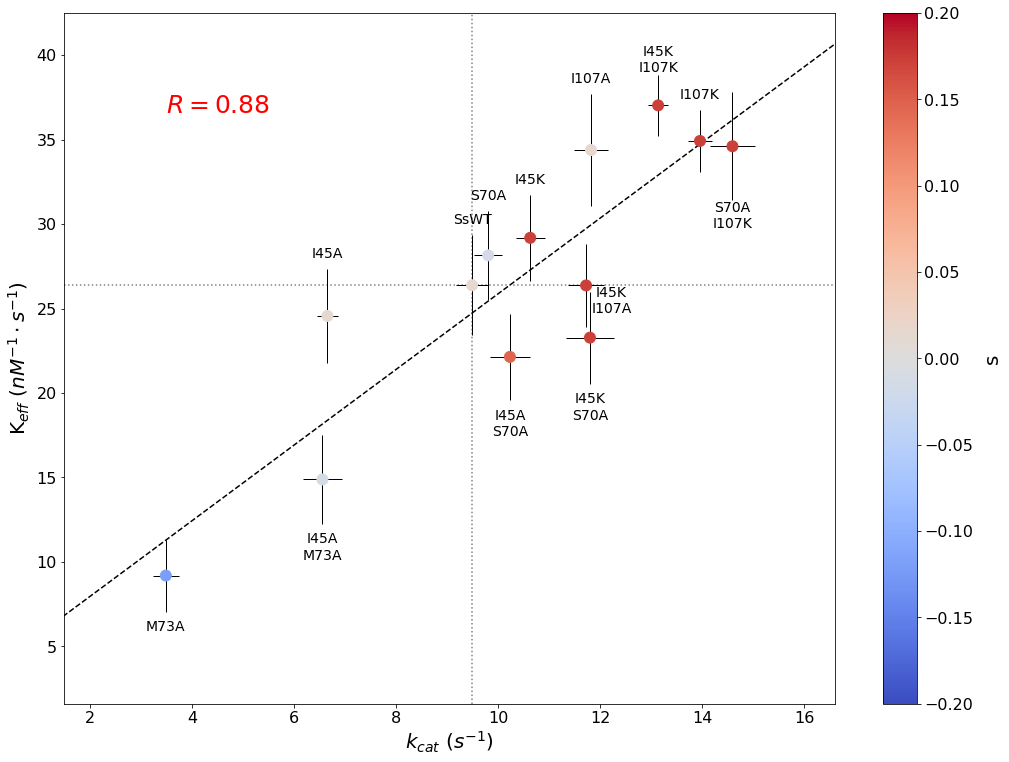

In [16]:
fit["color_p"] = fit.index.to_series().map(colordictFit)
fit["label_p"] = fit.index.to_series().str.replace('_','\n')
fout = dirOut2 + 'Function-Keff_vs_Kcat.pdf'
print (fout)

x_col = "kcat (1/s)"
y_col = "kcat/km (nM-1*s-1)"
x_err_col = "kcat_err"
y_err_col = "kcat/km_err"
createScatterWithLinearRegression(fit, fout, x_col, y_col, x_err_col, y_err_col)
#fit

In [17]:
vmax = fit["Vmax (uM/s)"]
vmaxerr = fit["Vmax_err"]
kcat = fit["kcat (1/s)"]
kcaterr =fit["kcat_err"]
km = fit["Km (uM)"]
kmerr = fit["Km_err"]
kcatkm = fit["kcat/km (nM-1*s-1)"]
kcatkmerr = fit["kcat/km_err"]
labels = fit["label_p"]
colors = fit["color_p"]

## SI Fig 2 ##

output/Function/12mut-Function-enzyme-kinetics-bargraph.pdf


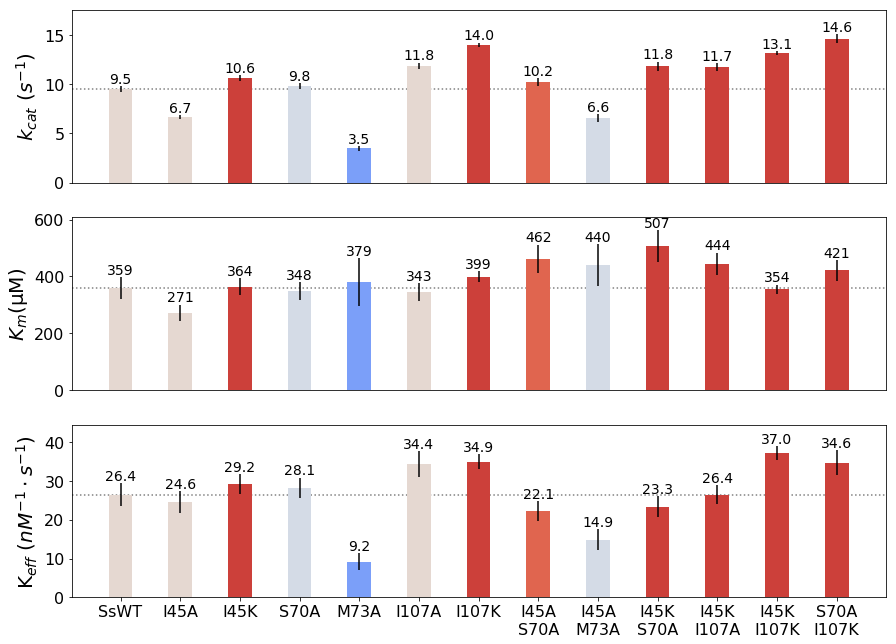

In [18]:
def autolabel(rects, ddg, ax, labels, err, numsig):
    for rect, h,e in zip(rects, ddg,err):
        height = h
        if numsig == 0:
            s = '%d'
        else:
            s = '%.1f'
        if (height >= 0):
            ax.text(rect.get_x() + rect.get_width()/2, height+e, s % height,ha='center', va='bottom')
        else:
            ax.text(rect.get_x() + rect.get_width()/2, height-e, s % height,ha='center', va='top')

            
fig = plt.figure(figsize=(figsize["Height"],figsize["Double"]))
gs = gridspec.GridSpec(nrows=3, ncols=1)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])

N = fit.shape[0]
ind = np.arange(N)  # the x locations for the groups
width = 0.4       # the width of the bars

ax0.axhline(y=kcat["SsWT"], color = "grey", linestyle = ":", zorder=0)
ax1.axhline(y=km["SsWT"], color = "grey", linestyle = ":", zorder=0)
ax2.axhline(y=kcatkm["SsWT"], color = "grey", linestyle = ":", zorder=0)


rects0 = ax0.bar(ind, kcat, width, yerr=kcaterr, color=colors)
rects1 = ax1.bar(ind, km ,  width, yerr=kmerr,color=colors)
rects2 = ax2.bar(ind, kcatkm, width, yerr=kcatkmerr, color=colors)

fig_title = u'Kinetic parameters'
#sub_title = u'$\u0394\u0394G_{T}^{\u2021}$' + u'$=-RTln[(kcat/Km)_{Mut}/(kcat/Km)_{WT}]$'
#plt.suptitle(fig_title, fontsize=14)
#ax.set_title(sub_title, fontsize=12)
ax0.set_ylabel(labeldict["kcat (1/s)"] )
ax1.set_ylabel(labeldict["Km (uM)"] )
ax2.set_ylabel(labeldict["kcat/km (nM-1*s-1)"] )

ax0.set_xticks(ind)
ax1.set_xticks(ind)
ax2.set_xticks(ind)

ax0.set_xticklabels(labels)
ax1.set_xticklabels(labels)
ax2.set_xticklabels(labels)

ax0.set_ylim([0, max(kcat)*1.2])
ax1.set_ylim([0, max(km)*1.2])
ax2.set_ylim([0, max(kcatkm)*1.2])

ax0.tick_params(axis='both') 
ax1.tick_params(axis='both') 
ax2.tick_params(axis='both') 

ax0.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off') 
ax1.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off') 

autolabel(rects0, kcat, ax0,  labels, kcaterr, 2)
autolabel(rects1, km, ax1, labels, kmerr, 0)
autolabel(rects2, kcatkm, ax2, labels, kcatkmerr, 1)

#ax.axhline(y=0, color = "black")
fig.show()
fout = dirOut2 + 'Function-enzyme-kinetics-bargraph.pdf'
print (fout)
fig.savefig(fout)

In [19]:
ddG_u

,Km (uM),kcat (1/s),kcat/km (nM-1*s-1),Km/wt,kcat/wt,keff/wt,log_Km/wt,log_kcat/wt,log_keff/wt,ddG_Km (kcal/mol),ddG_kcat (kcal/mol),ddG_keff (kcal/mol)
Protein,,,,,,,,,,,,
I45A,271+/-30,6.66+/-0.21,24.6+/-2.8,0.75+/-0.11,0.701+/-0.033,0.93+/-0.15,-0.29+/-0.06,-0.355+/-0.020,-0.07+/-0.07,0.17+/-0.04,0.214+/-0.012,0.04+/-0.04
I45K,364+/-30,10.63+/-0.28,29.2+/-2.5,1.01+/-0.14,1.12+/-0.05,1.11+/-0.16,0.01+/-0.06,0.113+/-0.019,0.10+/-0.06,-0.01+/-0.04,-0.068+/-0.012,-0.06+/-0.04
S70A,348+/-31,9.81+/-0.28,28.1+/-2.6,0.97+/-0.13,1.03+/-0.05,1.07+/-0.16,-0.03+/-0.06,0.030+/-0.021,0.07+/-0.06,0.018+/-0.035,-0.018+/-0.013,-0.04+/-0.04
M73A,(3.8+/-0.8)e+02,3.49+/-0.25,9.2+/-2.1,1.06+/-0.26,0.368+/-0.029,0.35+/-0.09,0.06+/-0.11,-1.000+/-0.034,-1.05+/-0.11,-0.04+/-0.06,0.602+/-0.021,0.63+/-0.07
I107A,344+/-32,11.82+/-0.34,34.4+/-3.3,0.96+/-0.13,1.25+/-0.06,1.30+/-0.19,-0.04+/-0.06,0.223+/-0.021,0.26+/-0.06,0.025+/-0.035,-0.134+/-0.013,-0.16+/-0.04
I107K,400+/-20,13.96+/-0.23,34.9+/-1.8,1.11+/-0.13,1.47+/-0.06,1.32+/-0.16,0.10+/-0.05,0.385+/-0.018,0.28+/-0.05,-0.063+/-0.031,-0.232+/-0.011,-0.167+/-0.032
I45A_S70A,(4.6+/-0.5)e+02,10.2+/-0.4,22.1+/-2.5,1.28+/-0.20,1.08+/-0.06,0.84+/-0.13,0.25+/-0.07,0.077+/-0.024,-0.17+/-0.07,-0.15+/-0.04,-0.046+/-0.015,0.10+/-0.04
I45A_M73A,(4.4+/-0.7)e+02,6.6+/-0.4,14.9+/-2.6,1.23+/-0.24,0.69+/-0.05,0.56+/-0.12,0.21+/-0.08,-0.371+/-0.031,-0.58+/-0.09,-0.12+/-0.05,0.223+/-0.019,0.35+/-0.06
I45K_S70A,(5.1+/-0.6)e+02,11.8+/-0.5,23.3+/-2.7,1.41+/-0.22,1.24+/-0.07,0.88+/-0.14,0.34+/-0.07,0.215+/-0.025,-0.13+/-0.07,-0.21+/-0.04,-0.129+/-0.015,0.08+/-0.04


In [20]:
##ddG of transition state
ddGTS = fit.filter(regex='ddG')

ddGTS = ddGTS.drop('SsWT', axis=0)
labels = ddGTS.index.str.replace('_' , '\n')
ddGTS


,ddG_Km (kcal/mol),ddG_Km (kcal/mol)_err,ddG_kcat (kcal/mol),ddG_kcat (kcal/mol)_err,ddG_keff (kcal/mol),ddG_keff (kcal/mol)_err
Protein,,,,,,
I45A,0.170,0.040,0.214,0.012,0.040,0.040
I45K,-0.010,0.040,-0.068,0.012,-0.060,0.040
S70A,0.018,0.035,-0.018,0.013,-0.040,0.040
M73A,-0.040,0.060,0.602,0.021,0.630,0.070
I107A,0.025,0.035,-0.134,0.013,-0.160,0.040
I107K,-0.063,0.031,-0.232,0.011,-0.167,0.032
I45A_S70A,-0.150,0.040,-0.046,0.015,0.100,0.040
I45A_M73A,-0.120,0.050,0.223,0.019,0.350,0.060
I45K_S70A,-0.210,0.040,-0.129,0.015,0.080,0.040


## Figure 5 - c ##

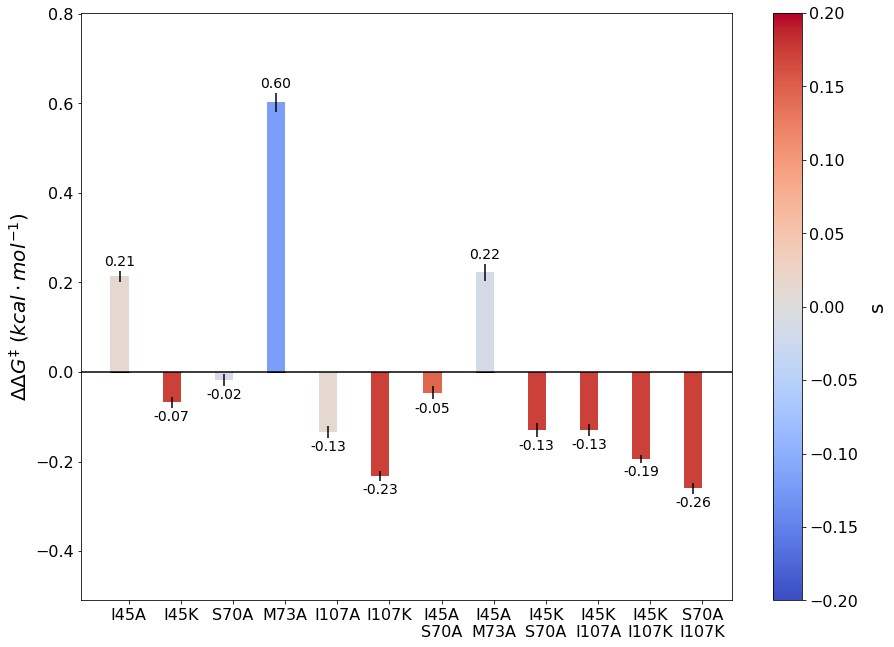

In [21]:
fig = plt.figure(figsize=(figsize["Height"],figsize["Double"])) 
gs = gridspec.GridSpec(nrows=1, ncols=1)
ax = plt.subplot(gs[0])

N = ddGTS.shape[0]
ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars
labels = ddGTS.index.str.replace('_' , '\n')

#dummy data for legend
rects3 = ax.bar(ind, [0]*N, width, color="white",edgecolor='black')
#rects4 = ax.bar(ind+width,[0]*N , width, color="white", edgecolor='black', hatch='//')

rects1 = ax.bar(ind, ddGTS["ddG_kcat (kcal/mol)"] , width, yerr = ddGTS["ddG_kcat (kcal/mol)_err"], color=[colordictFit[p] for p in ddGTS.index])
#rects2 = ax.bar(ind+width, ddGTS["ddG_keff (kcal/mol)"] , width, yerr = ddGTS["ddG_keff (kcal/mol)_err"], color=[colordictFit[p] for p in ddGTS.index],  hatch='//')
#df["ddG_EnergyActivation (kcal/mol)"].plot(kind='bar', color=[colordict[p] for p in df["Prot"]])

ax.set_ylabel(labeldict["ddG_TS (kcal/mol)"])
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(labels, fontsize = 16)
ax.set_ylim([min(ddGTS["ddG_kcat (kcal/mol)"])-0.25, max(ddGTS["ddG_kcat (kcal/mol)"])+0.2])
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
##lgd = ax.legend(rects3[0], labeldict["ddG_kcat (kcal/mol)"], loc=2)
##lgd.get_frame().set_linewidth(0.0)

def autolabelbar(rects, ddg, err, y_shift):
    for rect, h, e in zip(rects, ddg, err):
        height = h
        if (height >= 0):
            ax.text(rect.get_x() + rect.get_width()/2, height+y_shift+e, '%.2f' % height, ha='center', va='bottom',size=14)
        if (height < 0):
            ax.text(rect.get_x() + rect.get_width()/2, height-y_shift-e, '%.2f' % height, ha='center', va='top',size=14)

maxvalue = abs(ddGTS[['ddG_kcat (kcal/mol)','ddG_keff (kcal/mol)']]).max().max()
ordermag = pow(10, (math.ceil(math.log10(maxvalue))))
y_shift = ordermag/10 * 0.05

autolabelbar(rects1, ddGTS["ddG_kcat (kcal/mol)"],ddGTS["ddG_kcat (kcal/mol)_err"],  y_shift)
#autolabelbar(rects2, ddGTS["ddG_keff (kcal/mol)"], ddGTS["ddG_keff (kcal/mol)_err"], y_shift)
ax.tick_params(axis='both') 
ax.axhline(y=0, color = "black")

## red to blue colorbar
cmap = mpl.cm.get_cmap("coolwarm")
norm = mpl.colors.Normalize(vmin= -0.2, vmax=0.2)
m = cm.ScalarMappable(norm=norm, cmap=cmap)
m.set_array([])
cbar = plt.colorbar(m)
cbar.set_label('s', rotation=90,labelpad=10)

fig.show()